In [1]:
# Connect to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Navigate to necessary folder
%cd '/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework6'

/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework6


In [4]:
import os

# Path to your directory within Google Drive
# Path where the shortcut to the shared folder is placed
# Replace '<YourPathHere>' with the actual path to the shortcut in your Drive
drive_path = '/content/drive/My Drive/Data 255 Spring 2024/HW_06 Dataset'

#

# Change the current working directory to your specific folder
os.chdir(drive_path)

# Verify the current working directory
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  /content/drive/.shortcut-targets-by-id/1KkSYKqdmO1GE6gSP38UCsOrYZ7QUGj-x/HW_06 Dataset


In [4]:
ls

metadata.csv  testA/  testB/  trainA/  trainB/


# 1) Load the Monet-To-Photos Dataset using Pytorch.

In [5]:
!pip install torch_snippets torch_summary --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 67.0 MB/s eta

In [6]:
# Load the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import dataloader
# Pillow package for various image related tasks
from PIL import Image
# Simplify common tasks in Python realted to loading, visualizing data
from torch_snippets import *
from torchvision import transforms
from torchvision.utils import make_grid
# Quick summary of model
from torchsummary import summary
import itertools
import random
from tqdm import tqdm
import os
from IPython.display import display


### Looking at some training images shapes

### Defining image transformations (augmentation)

In [7]:
IMAGE_SIZE = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.33)),
    transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
 ])

### Making out Train and Test Dataset

In [8]:
class Monet2Photos(Dataset):
    def __init__(self, monets_dir, photos_dir):
        # Use glob to get all the image files in the directories
        all_monets = Glob(f'{monets_dir}/*.jpg')
        all_photos = Glob(f'{photos_dir}/*.jpg')
      # Randomly select 60 from train and 30 from test images from each list
        self.monets = random.sample(all_monets, min(60, len(all_monets)))
        self.photos = random.sample(all_photos, min(30, len(all_photos)))

    def __getitem__(self, ix):
        monet = self.monets[ix % len(self.monets)]
        ### Choosing a random photo image to pair with the chosen monet image
        photo = choose(self.photos)
        monet_img = Image.open(monet).convert('RGB')
        photo_img = Image.open(photo).convert('RGB')
        return monet_img, photo_img

    def __len__(self): return max(len(self.monets), len(self.photos))
    def choose(self): return self[randint(len(self))]

    def collate_fn(self, batch): #batch function
        ### The zip function breaks the tuples into two lists
        srcs, trgs = list(zip(*batch))

        srcs = torch.cat([transform(img)[None] for img in srcs], 0).to(device).float()
        trgs = torch.cat([transform(img)[None] for img in trgs], 0).to(device).float()
        return srcs.to(device), trgs.to(device)

### Initialize the dataloader

In [9]:
trn_ds = Monet2Photos('trainA', 'trainB')
val_ds = Monet2Photos('testA', 'testB')

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=5, shuffle=True, collate_fn=val_ds.collate_fn)

### Define weights function

In [10]:
# Initialize weights of conv and batchnormal layers in nn
# to help stablize the learning process

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        # intialize with mean 0.0 and std dev
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        # check if bias exists and None, initialize to 0
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        # Initialize with normal dist at 1 and std dev at 0.02
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

### Define Residual block

In [11]:
'''
Define a residual block to help with vanishing gradient problem,
and help with training a deeper network
'''
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            # Adds a padding to the input tensor, to reduce boundry artifacts
            # padding of size 1 implies a single row or col at edge of each input
            nn.ReflectionPad2d(1),
            # Defines a 2D conv layer, no of inputs same as outputs, kernel=3
            nn.Conv2d(in_features, in_features, 3),
            # applies instance normalization, helps stablize learning process
            # same as batch normal. but normal. access each channel
            # in each data instance independently
            nn.InstanceNorm2d(in_features),
            # Activation function
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )
    # Computes output of block
    def forward(self, x):
        return x + self.block(x)

### Generator Class

In [12]:
class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        out_features = 64
        channels = 3
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
        self.apply(weights_init_normal)
    def forward(self, x):
        return self.model(x)

### Discriiminator Class

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weights_init_normal)

    def forward(self, img):
        return self.model(img)

### How to generate samples from cGan

In [14]:
@torch.no_grad()
def generate_sample():
    data = next(iter(val_dl))
    G_AB.eval()
    G_BA.eval()

    real_A, real_B = data
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    show(image_grid.detach().cpu().permute(1,2,0).numpy(), sz=12)

# 2) Create and train Cycle GAN on this dataset.

### Define Generato Training Step

In [15]:
def generator_train_step(Gs, optimizer, real_A, real_B):
    G_AB, G_BA = Gs
    optimizer.zero_grad()
    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)

    loss_identity = (loss_id_A + loss_id_B) / 2
    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))

    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)

    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
    loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
    loss_G.backward()
    optimizer.step()
    return loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B

### Define Discrimitor training step

In [16]:
def discriminator_train_step(D, real_data, fake_data, optimizer):
    optimizer.zero_grad()
    loss_real = criterion_GAN(D(real_data), torch.Tensor(np.ones((len(real_data), 1, 16, 16))).to(device))
    loss_fake = criterion_GAN(D(fake_data.detach()), torch.Tensor(np.zeros((len(real_data), 1, 16, 16))).to(device))
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer.step()
    return loss_D

In [17]:
G_AB = GeneratorResNet().to(device)
G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_cyc, lambda_id = 10.0, 5.0

In [18]:
ls

metadata.csv  testA/  testB/  trainA/  trainB/


### TRaing the cycle GAN

EPOCH: 1.000  loss_D: 0.354  loss_G: 5.006  loss_GAN: 0.410  loss_cycle: 0.321  loss_identity: 0.278  (2570.61s - 0.00s remaining)

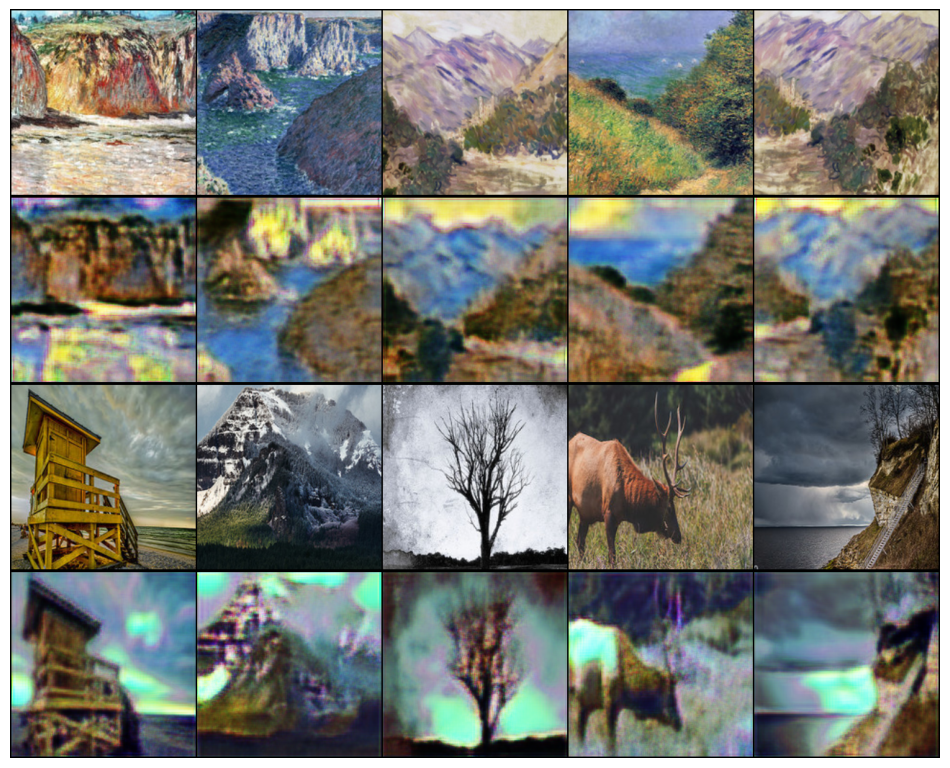

In [19]:
n_epochs = 1
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        real_A, real_B = batch

        loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B = generator_train_step((G_AB,G_BA), optimizer_G, real_A, real_B)
        loss_D_A = discriminator_train_step(D_A, real_A, fake_A, optimizer_D_A)
        loss_D_B = discriminator_train_step(D_B, real_B, fake_B, optimizer_D_B)
        loss_D = (loss_D_A + loss_D_B) / 2

        log.record(epoch+(1+bx)/N, loss_D=loss_D.item(), loss_G=loss_G.item(),
                   loss_GAN=loss_GAN.item(), loss_cycle=loss_cycle.item(),
                   loss_identity=loss_identity.item(), end='\r')
    generate_sample()

    log.report_avgs(epoch+1)

# 3) Show your results( Few converted images).

# 4) load your favorite image (or your picture) apply Cyclegan and upload it with the report.

In [24]:
%cd '/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework6'

/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework6


In [28]:
# Specify the path to save the model

model_path = 'G_AB_model_state.pth'

# Save the model's state dictionary
#torch.save(G_AB.state_dict(), model_path)

In [26]:
ls

Homework6.ipynb  testA/  testB/  trainA/  trainB/


In [29]:
# Ensure the directory exists
#directory = os.path.dirname(model_path)
#if not os.path.exists(directory):
#    os.makedirs(directory)

# Now save the model
torch.save(G_AB.state_dict(), model_path)

In [30]:
# Load the model weights
#model_path = 'G_AB_model.pth'
G_AB.load_state_dict(torch.load(model_path, map_location=device))
G_AB.eval()  # Set the model to evaluation mode

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

In [35]:
ls

01140.jpg  G_AB_model_state.pth  Homework6.ipynb  testA/  testB/  trainA/  trainB/


In [36]:
%matplotlib inline

# Assume transform is already defined based on the notebook's setup
transform = transforms.Compose([
    transforms.Resize(int(256*1.33)),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load your image
img_path = '01140.jpg'
img = Image.open(img_path).convert('RGB')
img.show()
img_transformed = transform(img).unsqueeze(0)  # Add batch dimension

In [37]:
# Apply the model to your image
with torch.no_grad():
    output = G_AB(img_transformed)

# Convert the output tensor to a PIL Image and save it
output_img = output.squeeze().detach().cpu()
output_img = (output_img + 1) / 2  # Assuming the output is in the range [-1, 1]
output_img = transforms.ToPILImage()(output_img)
output_img.save("transformed_image.jpg")